# Analysis of Emergency Maternal Care Deprivation in Kano and Lagos, Nigeria
> Note: This notebook requires the local environment dependencies listed in our [requirements.txt] (requirements.txt) file. Use this file to install the required packages in a virtual environment.

> To excecute OpenRouteService functions, it is required to install the [library dependencies](https://github.com/GIScience/openrouteservice-examples#local-installation). You should either have an [openrouteservice API key](https://openrouteservice.org/dev/#/signup) or a local ORS environment to complete the analysis.

The model concepts and processes are described in our documentation. The [Dataset-interpretability](https://github.com/urbanbigdatacentre/ideamaps-models/blob/a4084fb650424ac575941cdacb71421aa882bae4/models/emergency-maternal-care/kano/dataset-interpretability.md) file describes the rationale behind this model.

## Workflow:
The notebook is divided into the following sections:

1. Initial Setup
2. Data Preparation
3. Travel time estimates
4. Two-step floating catchment area (2SFCA) analysis
5. Results

## 1. Initial Setup

## Setting up the virtual environment

```bash
# Create a new virtual environment
# It is recommended to create this virtual environment in the scripts folder
python -m venv .venv

# Activate the virtual environment
source .venv/bin/activate
pip install -r requirements.txt
```

## To run your notebook in VS Code

```bash
pip install -U ipykernel
python -m ipykernel install --user --name=.venv
```

In [1]:
import os
from IPython.display import display
import requests

import folium
from folium.plugins import MarkerCluster
import openrouteservice
import time

import pandas as pd
import numpy as np
import fiona as fn
import geopandas as gpd
from shapely.geometry import shape, mapping
from shapely.geometry import Point
from shapely.geometry import box
from scipy.spatial import cKDTree
from tqdm import tqdm

import rasterio
from rasterio.transform import xy
from rasterio.mask import mask
import rasterstats as rs
import math

from pathlib import Path
from shapely.geometry import Polygon

# Used for scaling the data
from sklearn.preprocessing import MinMaxScaler

# Used for data analysis and visualization
import seaborn as sns
import matplotlib.pyplot as plt



## Preprocessing
In this study, users first requested an ORS Matrix API key from the [OpenRouteService](https://openrouteservice.org/) platform and subsequently interacted with the OpenRouteService API through the instantiation of the OpenRouteService client. This is the OpenRouteService [API documentation](https://openrouteservice.org/dev/#/api-docs/introduction) for ORS Core-Version 9.0.0. 

Generate a [API Key](https://openrouteservice.org/dev/#/home?tab=1) (Token) it is necessary to sign up at the OpenRouteService dashboard by using your E-mail address or sign up with your GitHub. After logging in, go to the Dashboard by clicking on your profile icon and navigate to the API Keys section. Click "Create API Key" to generate a free key and then choose a service plan (the free plan has limited requests per day). Copy the API Key and store it securely. 

OpenRouteService primarily uses API keys for authentication. However, if a token is required for certain endpoints, you can send a request with your API key in the Authorization header. This process facilitated various geospatial analysis functions, including isochrone generation.


### Option 1: Using an ORS API Key
Make sure you have a .env file in the root directory with the following content:
```bash
    OPENROUTESERVICE_API_KEY='your_api_key'
```

In [ ]:
# %%
# Read the api key from the .env file
from dotenv import load_dotenv
%load_ext dotenv
%dotenv
api_key = os.getenv('OPENROUTESERVICE_API_KEY')
client = openrouteservice.Client(key=api_key)

### Option 2: Using a local ORS service
Make sure you have set a local service that runs the OSM-based ORS API. 
```r
    # Insert R code from the local ORS service
```

For this study different kind of data were used. The dataset on healthcare facilities is sourced from a research ([Macharia, P.M. et al., 2023](https://doi.org/10.1038/s41597-023-02651-9)) which provides A geospatial database of close-to-reality travel times to obstetric emergency care in 15 Nigerian conurbations. The dataset were filtered by state name to isolate facilities in Kano and converted CSV file to shapefile based on coordinates using [QGIS](https://qgis.org/). 

The Level 2 administrative boundary data is sourced from [Humanitarian Data Exchange](https://data.humdata.org/) were used to correlate the isochrones and healthcare facility distribution with specific administrative regions. The data were filtered based on the administrative region name (lganame) to focus the analysis on Kano.

Despite being official, administrative boundaries may not reflect the actual patterns of human settlement or economic activity. Therefore, the team used the Functional Urban Area (FUA) as a complementary definition of the study areas. The FUA is defined by [the Joint Research Centre of the European Commission](https://commission.europa.eu/about/departments-and-executive-agencies/joint-research-centre_en) as the actual urban sprawl and human activities, encompassing the core city and economically or socially integrated surrounding regions. The FUA was obtained from [the Global Human Settlement Layer (GHSL) ](https://human-settlement.emergency.copernicus.eu/)dataset, which provides spatial data for functional urban areas worldwide. 

* [Datasets of health facilities](https://doi.org/10.6084/m9.figshare.22689667.v2) (15/07/2023)
* [Shapefile of district boundaries](https://data.humdata.org/dataset/nigeria-admin-level-2) - Admin Level 2 (data from Humanitarian Data Exchange, 25/11/2015)
* [Functional Urban Areas](https://human-settlement.emergency.copernicus.eu/download.php?ds=FUA) - data from Global Human Settlement Layer(2015)

### Option 1: Kano
If you want to process data for the city of Kano, use the following code to filter the dataset. 


In [7]:
# Set paths to access Kano data
# Define directories
data_inputs = '../scripts/Kano/data-inputs/'
data_temp = '../scripts/Kano/data-temp/'
model_outputs = '../kano/'

### Option 2: Lagos
If you want to process data for the city of Kano, use the following code to filter the dataset. 

In [2]:
# Set paths to access Lagos data
# Define directories
data_inputs = '../scripts/Lagos/data-inputs/'
data_temp = '../scripts/Lagos/data-temp/'
model_outputs = '../lagos/'

## Data Collection

### 1.1 Validated healthcare facilities for Kano
note: to describe the process to validate healthcare facilities

In [8]:
healthcare_facilities_validated = gpd.read_file(data_inputs + 'healthcare_facilities.geojson')

In [9]:
healthcare_facilities_validated

,orig_order,state,lga,ward,urban_conurb,uid,facility_code,ontime_code,facility_name,reg_number,...,latitude,longitude,operation_status,registration_status,license_status,created,last_updated,last_updated_ontime,hcf_id,geometry
0,117,1,Agege,Dopemu,1,25250613.0,24/01/1/2/2/0001,100101001,Al-Imaan Hospital and Maternity Home,None,...,6.61300,3.31549,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,1,POINT (3.31549 6.613)
1,400,1,Agege,Keke,1,58886840.0,24/01/1/2/2/0009,100101002,J.A Lashman Hospital,None,...,6.62262,3.33436,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-28 10:09:17,28/09/2022 09:00,2,POINT (3.33436 6.62262)
2,399,1,Agege,Orile (Agege),1,70566198.0,24/01/1/2/1/0001,100101003,Orile Agege General Hospital,None,...,6.63477,3.30360,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,3,POINT (3.3036 6.63477)
3,118,1,Agege,Powerline,1,81930847.0,24/01/1/2/2/0016,100101004,Molayo Medical Centre,None,...,6.63309,3.31291,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 10:30:39,28/09/2022 09:00,4,POINT (3.31291 6.63309)
4,83,1,Agege,Papa Ashafa,1,18545103.0,24/01/1/1/1/0068,100101005,Mucas Hospital,None,...,6.61240,3.30348,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 11:16:07,28/09/2022 09:00,5,POINT (3.30348 6.6124)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2047,1,Surulere,Nuru Oniwo,1,56048382.0,24/20/1/1/1/0099,100120069,Fajip Hospital (Annex),None,...,6.49779,3.34456,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-25 11:24:32,28/09/2022 09:00,787,POINT (3.34456 6.49779)
787,2048,1,Surulere,Muniru Baruwa,1,51776203.0,24/08/1/2/2/0051,100120070,St Maria Hospital,None,...,6.54848,3.23181,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,788,POINT (3.23181 6.54848)
788,2049,1,Surulere,Airways,1,52229738.0,24/20/1/2/2/0068,100120071,Peace Way Hospital and Maternity,None,...,6.55846,3.24249,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,789,POINT (3.24249 6.55846)
789,762,4,Egor,Unknown,4,NaN,None,100401001,Total Health Trust Medical Centre,None,...,6.54187,3.36499,Operational,None,None,NaT,NaT,28/09/2022 09:00,790,POINT (3.36499 6.54187)


### 1.2 Healthcare facilities in Lagos
note: Due to the absence of local expert validation in Lagos, the classification for validation is determine based on the ownership provided in the [datasets of health facilities](https://doi.org/10.6084/m9.figshare.22689667.v2).

In [10]:
healthcare_facilities_validated = gpd.read_file(data_inputs + 'healthcare_facilities.geojson')

To assing the healthcare facilities to the different categories, we used the following criteria:
- **Public**: Facilities owned by the government (1), the military (3) or the police (6) health authorities. 
- **Private**: Facilities owned by private individuals or other organizations.

In [11]:
conditions = [
    healthcare_facilities_validated['specific_owner'].isin([1, 3, 6]),
    healthcare_facilities_validated['specific_owner'].isin([2, 4, 5])
]
choices = ['Public Comprehensive EmOC', 'Private Comprehensive EmOC']

# Explicitly set the default to a string
healthcare_facilities_validated['Validation'] = np.select(
    conditions, choices, default='Other'
)

In [12]:
healthcare_facilities_validated

,orig_order,state,lga,ward,urban_conurb,uid,facility_code,ontime_code,facility_name,reg_number,...,longitude,operation_status,registration_status,license_status,created,last_updated,last_updated_ontime,hcf_id,geometry,Validation
0,117,1,Agege,Dopemu,1,25250613.0,24/01/1/2/2/0001,100101001,Al-Imaan Hospital and Maternity Home,None,...,3.31549,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,1,POINT (3.31549 6.613),Private Comprehensive EmOC
1,400,1,Agege,Keke,1,58886840.0,24/01/1/2/2/0009,100101002,J.A Lashman Hospital,None,...,3.33436,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-28 10:09:17,28/09/2022 09:00,2,POINT (3.33436 6.62262),Private Comprehensive EmOC
2,399,1,Agege,Orile (Agege),1,70566198.0,24/01/1/2/1/0001,100101003,Orile Agege General Hospital,None,...,3.30360,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,3,POINT (3.3036 6.63477),Public Comprehensive EmOC
3,118,1,Agege,Powerline,1,81930847.0,24/01/1/2/2/0016,100101004,Molayo Medical Centre,None,...,3.31291,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 10:30:39,28/09/2022 09:00,4,POINT (3.31291 6.63309),Private Comprehensive EmOC
4,83,1,Agege,Papa Ashafa,1,18545103.0,24/01/1/1/1/0068,100101005,Mucas Hospital,None,...,3.30348,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-03-04 11:16:07,28/09/2022 09:00,5,POINT (3.30348 6.6124),Private Comprehensive EmOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2047,1,Surulere,Nuru Oniwo,1,56048382.0,24/20/1/1/1/0099,100120069,Fajip Hospital (Annex),None,...,3.34456,Operational,Registered,Licensed,2018-01-01 01:01:01,2020-02-25 11:24:32,28/09/2022 09:00,787,POINT (3.34456 6.49779),Private Comprehensive EmOC
787,2048,1,Surulere,Muniru Baruwa,1,51776203.0,24/08/1/2/2/0051,100120070,St Maria Hospital,None,...,3.23181,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,788,POINT (3.23181 6.54848),Private Comprehensive EmOC
788,2049,1,Surulere,Airways,1,52229738.0,24/20/1/2/2/0068,100120071,Peace Way Hospital and Maternity,None,...,3.24249,Operational,Unknown,Unknown,2018-01-01 01:01:01,2018-01-01 01:01:01,28/09/2022 09:00,789,POINT (3.24249 6.55846),Private Comprehensive EmOC
789,762,4,Egor,Unknown,4,NaN,None,100401001,Total Health Trust Medical Centre,None,...,3.36499,Operational,None,None,NaT,NaT,28/09/2022 09:00,790,POINT (3.36499 6.54187),Private Comprehensive EmOC


### 2. Population Grid Data (1km resolution) from WorldPop
note: explain the rational for female population between 15-49 years old

** Add a note to explain the process applies for the two cities **

In [8]:
study_area = gpd.read_file(data_inputs + '100mGrid.gpkg')
raster_path = data_inputs + 'nga_f_15_49_2015_1km.tif'

In [9]:
with rasterio.open(raster_path) as dataset:
    geometries = [study_area.geometry.unary_union.__geo_interface__]
    clipped_image, clipped_transform = mask(dataset, geometries, crop=True)
    band1 = clipped_image[0] # Read the first band of the raster

In [11]:
out_meta = dataset.meta.copy()
out_meta.update({
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })

In [12]:
with rasterio.open(data_inputs + 'lagos_nga_f_15_49_2015_1km.tif', "w", **out_meta) as dest:
    dest.write(clipped_image)

### Adding population data at 1km grid to 100m grid

In [3]:
# reading in geotiff file as numpy array
def read_tif(file: Path):
    if not file.exists():
        raise FileNotFoundError(f'File {file} not found')

    with rasterio.open(file) as dataset:
        arr = dataset.read()  # (bands X height X width)
        nodata = dataset.nodata
        transform = dataset.transform
        crs = dataset.crs

    # Replace NoData value with NaN
    if nodata is not None:
        arr[arr == nodata] = np.nan

    return arr.transpose((1, 2, 0)), transform, crs

def raster2vector(arr, transform, crs) -> gpd.GeoDataFrame:
    height, width, bands = arr.shape

    # Generate pixel coordinates
    geometries = []
    pixel_values = []

    for row in range(height):
        for col in range(width):
            x_min, y_max = transform * (col, row)  # Top-left corner
            x_max, y_min = transform * (col + 1, row + 1)  # Bottom-right corner

            pixel_value = arr[row, col].tolist()[0]  # Convert numpy array to list
            polygon = Polygon([(x_min, y_max), (x_max, y_max), (x_max, y_min), (x_min, y_min)])

            geometries.append(polygon)
            pixel_values.append(pixel_value)

    # Convert to DataFrame
    gdf = gpd.GeoDataFrame({'pop_grid_pop': pixel_values, 'geometry': geometries}, crs=crs)

    return gdf

epsg = 'EPSG:32632'

In [4]:
# Preparing grid
grid_file = data_inputs + '100mGrid.gpkg'
grid = gpd.read_file(grid_file)
grid = grid.to_crs(epsg)
grid['grid_id'] = range(len(grid))
grid = grid[['grid_id', 'geometry','rowid', 'latitude', 'lat_min', 'lat_max', 'longitude', 'lon_min','lon_max']].set_geometry('geometry')
grid

,grid_id,geometry,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max
0,0,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659
1,1,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656
2,2,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653
3,3,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651
4,4,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648
...,...,...,...,...,...,...,...,...,...
325349,325349,"POLYGON ((-74134.769 717795.942, -74023.561 71...",325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533
325350,325350,"POLYGON ((-74136.108 717705.962, -74024.9 7177...",325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529
325351,325351,"POLYGON ((-74137.447 717615.981, -74026.239 71...",325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525
325352,325352,"POLYGON ((-74138.785 717526.001, -74027.577 71...",325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522


In [5]:
# Count buildings per grid cell

# Loading Google building footprints
building_file = data_inputs + 'Lagos_GOBv3.gpkg'
buildings = gpd.read_file(building_file)
buildings = buildings.to_crs(epsg)
buildings['centroid'] = buildings['geometry'].centroid

# Joining buildings to grid
grid_buildings = grid.sjoin(buildings.set_geometry('centroid').drop(columns='geometry'), how='inner', predicate='intersects')
grid_buildings = grid_buildings.groupby('grid_id')

# Counting buildings per grid
building_counts = grid_buildings.size().rename('bcount')

# Adding building count to grid cells
grid = grid.merge(building_counts, on='grid_id', how='left')

# Assign building count 0 to cells with no buildings (NaN)
grid['bcount'] = grid['bcount'].fillna(0)
grid

,grid_id,geometry,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,bcount
0,0,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0
1,1,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0
2,2,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0
3,3,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0
4,4,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0
...,...,...,...,...,...,...,...,...,...,...
325349,325349,"POLYGON ((-74134.769 717795.942, -74023.561 71...",325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533,0.0
325350,325350,"POLYGON ((-74136.108 717705.962, -74024.9 7177...",325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529,1.0
325351,325351,"POLYGON ((-74137.447 717615.981, -74026.239 71...",325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525,0.0
325352,325352,"POLYGON ((-74138.785 717526.001, -74027.577 71...",325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522,0.0


In [6]:
# Adding population data at 1km grid to finer grid
from pathlib import Path

data_path = Path(data_inputs)

# Loading coarse pop data
pop_file = data_path / 'lagos_nga_f_15_49_2015_1km.tif'
pop_raster, transform, crs = read_tif(pop_file)

# Converting the raster grid to vector data
pop_grid = raster2vector(pop_raster, transform, crs)
pop_grid = pop_grid.to_crs(epsg)
pop_grid['pop_grid_id'] = range(len(pop_grid))
# pop_grid.to_parquet(data_path / 'sanity_check_pop.parquet')

# Assign coarse population data to finer grid based on the centroid locations of the finer grid cells
grid['centroid'] = grid['geometry'].centroid
grid = gpd.sjoin(grid.set_geometry('centroid'), pop_grid, how='left', predicate='within')
print(grid.columns)
grid = grid[['grid_id', 'bcount', 'pop_grid_id', 'geometry','rowid', 'latitude', 'lat_min', 'lat_max',
       'longitude', 'lon_min', 'lon_max']]
grid.head()

Index(['grid_id', 'geometry', 'rowid', 'latitude', 'lat_min', 'lat_max',
       'longitude', 'lon_min', 'lon_max', 'bcount', 'centroid', 'index_right',
       'pop_grid_pop', 'pop_grid_id'],
      dtype='object')


,grid_id,bcount,pop_grid_id,geometry,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max
0,0,0.0,8520,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659
1,1,0.0,8520,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656
2,2,0.0,8520,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653
3,3,0.0,8640,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651
4,4,0.0,8640,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648


In [7]:


print("Min value in raster:", np.min(pop_raster))


Min value in raster: nan


In [8]:
with rasterio.open(pop_file) as ds:
    print("NoData value:", ds.nodata)


NoData value: -3.4028230607370965e+38


In [9]:
print(grid['bcount'].sum())

3871094.0


In [10]:
# Calculate population weight (fraction of total population count that should be assigned to cell based on its building count)
grid_grouped_pop = grid.groupby('pop_grid_id')
building_count_pop = grid_grouped_pop['bcount'].sum().rename('pop_grid_bcount')
grid = grid.merge(building_count_pop, on='pop_grid_id', how='left')
grid['pop_weight'] = grid['bcount'] / grid['pop_grid_bcount']

# Compute disaggregated population count based on weight and building count at coarser cell level
grid = grid.merge(pop_grid, on='pop_grid_id', how='left')
grid['pop'] = grid['pop_grid_pop'] * grid['pop_weight']
grid.head()

,grid_id,bcount,pop_grid_id,geometry_x,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,pop_grid_bcount,pop_weight,pop_grid_pop,geometry_y,pop
0,0,0.0,8520,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0,NaN,NaN,"POLYGON ((-184838.209 713821.761, -183911.414 ...",NaN
1,1,0.0,8520,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0,NaN,NaN,"POLYGON ((-184838.209 713821.761, -183911.414 ...",NaN
2,2,0.0,8520,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0,NaN,NaN,"POLYGON ((-184838.209 713821.761, -183911.414 ...",NaN
3,3,0.0,8640,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0,NaN,NaN,"POLYGON ((-184849.423 712895.275, -183922.612 ...",NaN
4,4,0.0,8640,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0,NaN,NaN,"POLYGON ((-184849.423 712895.275, -183922.612 ...",NaN


In [11]:
# Saving to file
grid = grid.drop(columns=["geometry_y"])
grid.head()


,grid_id,bcount,pop_grid_id,geometry_x,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,pop_grid_bcount,pop_weight,pop_grid_pop,pop
0,0,0.0,8520,"POLYGON ((-184077.797 713168.196, -183966.398 ...",1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0,NaN,NaN,NaN
1,1,0.0,8520,"POLYGON ((-184079.195 713078.067, -183967.795 ...",2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0,NaN,NaN,NaN
2,2,0.0,8520,"POLYGON ((-184080.593 712987.938, -183969.193 ...",3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0,NaN,NaN,NaN
3,3,0.0,8640,"POLYGON ((-184081.99 712897.809, -183970.59 71...",4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0,NaN,NaN,NaN
4,4,0.0,8640,"POLYGON ((-184083.388 712807.68, -183971.988 7...",5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0,NaN,NaN,NaN


In [12]:
grid = grid.set_geometry("geometry_x")
grid = grid.to_crs(4326)
grid.to_file(data_temp + 'pop_grid.gpkg', driver='GPKG')

## 3. Estimating travel times (Spatial Analysis Pipeline) 
### Using OpenRouteService (ORS) Matrix API to calculate the travel time and distance from each population grid centroid to the healthcare facility 

note: this will generate a file 'OD_matrix_healthcare_pop_grid'

In [ ]:
origin_gdf = centroids_df
origin_name_column = 'grid_code'
destination_gdf = healthcare_facilities.dropna(subset=['geometry'])
destination_name_column = 'facility_name'

In [ ]:
origins = list(zip(origin_gdf.geometry.x, origin_gdf.geometry.y))

In [ ]:
destinations = list(zip(destination_gdf.geometry.x, destination_gdf.geometry.y))

In [ ]:
locations = origins + destinations

In [ ]:
origins_index = list(range(0, len(origins)))
destinations_index = list(range(len(origins), len(locations)))

In [ ]:
body = {'locations': locations,
       'destinations': destinations_index,
       'sources': origins_index,
       'metrics': ['distance', 'duration']}

In [ ]:
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

In [ ]:
response = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body, headers=headers)

In [ ]:
distances = response.json().get('distances', [])
durations = response.json().get('durations', [])

In [ ]:
distances_duration_matrix = []

In [ ]:
# Iterate over each origin (grid)
for origin_index, origin in origin_gdf.iterrows():
    origin_name = origin[origin_name_column]
    origin_x = origin.geometry.x
    origin_y = origin.geometry.y
    origin_distances = distances[origin_index]
    origin_durations = durations[origin_index]

    # find the minimum duration and the index of the minimum duration
    min_duration = min(origin_durations)
    min_index = origin_durations.index(min_duration)
    destination_index = destinations_index[min_index]
    dest_x, dest_y = locations[destination_index]
    filtered = healthcare_facilities[(destination_gdf.geometry.x == dest_x) & (destination_gdf.geometry.y == dest_y) ]
    destination_row = filtered.iloc[0]
    dest_name = destination_row[destination_name_column]

        # Append both the distance and duration for this origin-destination pair
    distances_duration_matrix.append([
            origin_name, origin_y, origin_x,
            dest_name, dest_y, dest_x,
            min_duration
        ])

In [ ]:
# Convert the results into a DataFrame
matrix_df = pd.DataFrame(distances_duration_matrix, columns=[
    'grid_code','origin_lat', 'origin_lon',
    'destination_name', 'dest_lat', 'dest_lon','min_duration'
])

In [ ]:
# Save to CSV
merged_df = pd.merge(matrix_df, grid_df[['grid_code', 'population']], on='grid_code', how='left')
merged_df.to_csv(data_temp + 'distance_duration_matrix_temp.csv', index=False)

In [ ]:
merged_df

In [ ]:
geometry = [Point(xy) for xy in zip(merged_df['dest_lon'], merged_df['dest_lat'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")

In [ ]:
gpkg_path = data_temp + 'distance_duration_matrix_temp.gpkg'
gdf.to_file(gpkg_path, layer="duration_matrix", driver="GPKG")

## Selecting the Healthcare facilities pool based on the OD Matrix

In [13]:
matrix_df = pd.read_csv(data_temp +'lagos-od-matrix-tenclosest.csv')

# need to normalise the filenames

In [15]:
matrix_df

,destination_id,validation,origin_id,duration_seconds,distance_km
0,167539,Private Comprehensive EmOC,59,0.00,0.00
1,167539,Private Comprehensive EmOC,33,123.72,1.05
2,167539,Private Comprehensive EmOC,61,207.44,2.32
3,167539,Private Comprehensive EmOC,63,218.46,2.44
4,167539,Private Comprehensive EmOC,25,234.59,2.69
...,...,...,...,...,...
3253535,310110,Public Comprehensive EmOC,3,NaN,NaN
3253536,310110,Public Comprehensive EmOC,21,NaN,NaN
3253537,310110,Public Comprehensive EmOC,54,NaN,NaN
3253538,310110,Public Comprehensive EmOC,68,NaN,NaN


**GRID CELLS WITHOUT TRAVEL TIME ESTIMATE**
If a grid cell has a NULL value in the travel estimate, we will remove it from the analysis. This is because we cannot calculate the 2SFCA without a travel time estimate.

In [25]:
# Calculate the percentage of missing values in the 'duration_seconds' column
percentage_na = (matrix_df['duration_seconds'].isna().sum() / len(matrix_df)) * 100
print(percentage_na)


6.2619177880093675


Removing the grid cells with NULL values in the travel time estimate will help us to avoid errors in the analysis.

In [30]:
# Removing rows with NaN values in the 'duration_seconds' column
matrix_df = matrix_df.dropna(subset=['duration_seconds'])



## Combining the OD matrix and the population data

Population data is the result of combining 1km grid data with 100m grid data. See [Section 2]() for more details.

In [31]:
# If stating the process here, read the file again
centroids_df = gpd.read_file(data_temp + 'pop_grid.gpkg')

In [32]:
centroids_df

,grid_id,bcount,pop_grid_id,rowid,latitude,lat_min,lat_max,longitude,lon_min,lon_max,pop_grid_bcount,pop_weight,pop_grid_pop,pop,geometry
0,0,0.0,8520,1,6.414217,6.413811,6.414622,2.826157,2.825655,2.826659,0.0,NaN,NaN,NaN,"POLYGON ((2.82566 6.41462, 2.82666 6.41462, 2...."
1,1,0.0,8520,2,6.413406,6.413000,6.413811,2.826154,2.825652,2.826656,0.0,NaN,NaN,NaN,"POLYGON ((2.82565 6.41381, 2.82666 6.41381, 2...."
2,2,0.0,8520,3,6.412595,6.412190,6.413000,2.826151,2.825649,2.826653,0.0,NaN,NaN,NaN,"POLYGON ((2.82565 6.413, 2.82665 6.413, 2.8266..."
3,3,0.0,8640,4,6.411784,6.411379,6.412190,2.826148,2.825646,2.826651,0.0,NaN,NaN,NaN,"POLYGON ((2.82565 6.41219, 2.82665 6.41219, 2...."
4,4,0.0,8640,5,6.410974,6.410568,6.411379,2.826146,2.825643,2.826648,0.0,NaN,NaN,NaN,"POLYGON ((2.82565 6.41138, 2.82665 6.41138, 2...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325349,325349,0.0,7919,325350,6.466914,6.466509,6.467319,3.815030,3.814527,3.815533,103.0,0.000000,117.478569,0.000000,"POLYGON ((3.81453 6.46732, 3.81553 6.46732, 3...."
325350,325350,1.0,7919,325351,6.466103,6.465698,6.466509,3.815026,3.814524,3.815529,103.0,0.009709,117.478569,1.140569,"POLYGON ((3.81453 6.46651, 3.81553 6.46651, 3...."
325351,325351,0.0,7919,325352,6.465293,6.464887,6.465698,3.815023,3.814520,3.815525,103.0,0.000000,117.478569,0.000000,"POLYGON ((3.81452 6.4657, 3.81553 6.4657, 3.81..."
325352,325352,0.0,7919,325353,6.464482,6.464076,6.464887,3.815019,3.814516,3.815522,103.0,0.000000,117.478569,0.000000,"POLYGON ((3.81452 6.46489, 3.81552 6.46489, 3...."


Note: The OD matrix contains ids for every grid cell ('destination_id') and the healtcare facilities ('origin_id').


In [40]:
pop_centroids_hcf = pd.merge(matrix_df, centroids_df[['rowid', 'longitude', 'latitude', 'lon_min', 'lat_min', 'lon_max', 'lat_max','bcount','pop_grid_bcount', 'pop_grid_pop', 'pop', 'geometry']], 
                     left_on='destination_id', right_on='rowid', how='left')

In [41]:
pop_centroids_hcf

,destination_id,validation,origin_id,duration_seconds,distance_km,rowid,longitude,latitude,lon_min,lat_min,lon_max,lat_max,bcount,pop_grid_bcount,pop_grid_pop,pop,geometry
0,167539,Private Comprehensive EmOC,59,0.00,0.00,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,20.0,2915.0,19129.324219,131.247508,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3...."
1,167539,Private Comprehensive EmOC,33,123.72,1.05,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,20.0,2915.0,19129.324219,131.247508,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3...."
2,167539,Private Comprehensive EmOC,61,207.44,2.32,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,20.0,2915.0,19129.324219,131.247508,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3...."
3,167539,Private Comprehensive EmOC,63,218.46,2.44,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,20.0,2915.0,19129.324219,131.247508,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3...."
4,167539,Private Comprehensive EmOC,25,234.59,2.69,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,20.0,2915.0,19129.324219,131.247508,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049801,309268,Public Comprehensive EmOC,266,5884.31,60.55,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.0,43.0,116.105339,0.000000,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3...."
3049802,309268,Public Comprehensive EmOC,289,7443.39,83.34,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.0,43.0,116.105339,0.000000,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3...."
3049803,309268,Public Comprehensive EmOC,310,7444.47,81.57,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.0,43.0,116.105339,0.000000,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3...."
3049804,309268,Public Comprehensive EmOC,293,7459.37,81.63,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.0,43.0,116.105339,0.000000,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3...."


## Option 1: Kano

To make the dataframe easier to read, we will rename the columns in the dataframe.

In [36]:
pop_centroids_hcf = pop_centroids_hcf.rename(columns={
    "longitude": "origin_lon",
    "latitude": "origin_lat",
    "lon_min": "origin_lon_min",
    "lat_min": "origin_lat_min",
    "lon_max": "origin_lon_max",
    "lat_max": "origin_lat_max",
    "rowid": "grid_id",
    "origin_id": "hcf_uid",
    "pop": "population"
})
columns_to_keep = ["grid_id", "origin_lon", "origin_lat", "origin_lon_min","origin_lat_min","origin_lon_max","origin_lat_max","population", "bcount","pop_grid_bcount", "pop_grid_pop","geometry", "hcf_uid", "duration_seconds", "distance_km"]
pop_centroids_hcf = pop_centroids_hcf[columns_to_keep]

In [37]:
pop_centroids_hcf

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,pop_grid_pop,geometry,hcf_uid,duration_seconds,distance_km
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,19129.324219,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",59,0.00,0.00
1,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,19129.324219,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",33,123.72,1.05
2,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,19129.324219,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",61,207.44,2.32
3,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,19129.324219,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",63,218.46,2.44
4,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,19129.324219,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",25,234.59,2.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049801,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,116.105339,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",266,5884.31,60.55
3049802,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,116.105339,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",289,7443.39,83.34
3049803,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,116.105339,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",310,7444.47,81.57
3049804,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,116.105339,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",293,7459.37,81.63


In [ ]:
distances_duration_matrix = pd.merge(pop_centroids_hcf, healthcare_facilities_validated[['hcf_id','facility_name', 'longitude', 'latitude', 'Local_Validation']], 
                     left_on='hcf_uid', right_on='hcf_id', how='left')

In [ ]:
distances_duration_matrix = distances_duration_matrix.rename(columns={
    "longitude": "dest_lon",
    "latitude": "dest_lat"
})
distances_duration_matrix = distances_duration_matrix.drop(columns=['hcf_uid'])

**Review** descriptions for this procedures

In [ ]:
distances_duration_matrix

In [ ]:
category_counts = healthcare_facilities_validated['Local_Validation'].value_counts()
print(category_counts)

In [ ]:
distances_duration_matrix['Local_Validation'] = distances_duration_matrix['Local_Validation'].replace({
    'Public/Private Basic EmOC': 'Private Basic EmOC',
    'Public/Private comprehensive EmOC (missionary Hospital)': 'Private Comprehensive EmOC'
})

In [ ]:
selected_categories = ['Public Comprehensive EmOC', 'Private Comprehensive EmOC', 
                       'Private Basic EmOC', 'Public Basic EmOC']

In [ ]:
distances_duration_matrix = distances_duration_matrix[
    distances_duration_matrix['Local_Validation'].isin(selected_categories)]

In [ ]:
distances_duration_matrix

In [ ]:
# creat subsets based on categories of 'Validation of HCFs Categorization'
categories = {
    "public_comprehensive_EmOC": ["Public Comprehensive EmOC"],
    "private_comprehensive_EmOC": ["Private Comprehensive EmOC"],
    "private_basic_EmOC": ["Private Basic EmOC"],
    "public_basic_EmOC": ["Public Basic EmOC"]
}

In [ ]:
subsets = {
    key: distances_duration_matrix[
        distances_duration_matrix['Local_Validation'].str.contains('|'.join(values), na=False)
    ]
    for key, values in categories.items()
}

In [ ]:
public_CEmOC = subsets["public_comprehensive_EmOC"]
private_CEmOC = subsets["private_comprehensive_EmOC"]
public_BEmOC = subsets["public_basic_EmOC"]
private_BEmOC = subsets["private_basic_EmOC"]

In [ ]:
public_CEmOC

In [ ]:
# Step 2: Define a function to get 3 smallest duration_seconds per grid_id for each category
def get_closest_3(df, n=3):
    return df.groupby('grid_id').apply(lambda x: x.nsmallest(n, 'duration_seconds')).reset_index(drop=True)

In [ ]:
# If the subsets are already created for each category, we apply the function to each subset:
public_CEmOC_closest_3 = get_closest_3(public_CEmOC)
private_CEmOC_closest_3 = get_closest_3(private_CEmOC)
public_BEmOC_closest_3 = get_closest_3(public_BEmOC)
private_BEmOC_closest_3 = get_closest_3(private_BEmOC)

In [ ]:
# Step 4: Concatenate the filtered results into a single DataFrame
distances_duration_matrix = pd.concat([
    public_CEmOC_closest_3, private_CEmOC_closest_3,
    public_BEmOC_closest_3, private_BEmOC_closest_3
])

distances_duration_matrix = distances_duration_matrix.groupby('grid_id').apply(lambda x: x.nsmallest(3, 'duration_seconds')).reset_index(drop=True)

In [ ]:
distances_duration_matrix

In [ ]:
geometry = [Point(xy) for xy in zip(distances_duration_matrix['origin_lon'], distances_duration_matrix['origin_lat'])]
gdf = gpd.GeoDataFrame(distances_duration_matrix, geometry=geometry, crs="EPSG:4326")

In [ ]:
gpkg_path = data_temp + 'distances_duration_3_closet_Emoc.gpkg'
gdf.to_file(gpkg_path, layer="distances_duration_3_closet_Emoc", driver="GPKG")

In [ ]:
# Review and remove
origin_dest = distances_duration_matrix

## Option 2: Lagos
This option differ from the Kano option in the validation data being estimated as part of the OD matrix estimation and the selection of healthcare facilities in the pool. 

In [63]:
pop_centroids_hcf = pop_centroids_hcf.rename(columns={
    "longitude": "origin_lon",
    "latitude": "origin_lat",
    "lon_min": "origin_lon_min",
    "lat_min": "origin_lat_min",
    "lon_max": "origin_lon_max",
    "lat_max": "origin_lat_max",
    "rowid": "grid_id",
    "origin_id": "hcf_uid",
    "pop": "population"
})
columns_to_keep = ["grid_id", "origin_lon", "origin_lat", "origin_lon_min","origin_lat_min","origin_lon_max","origin_lat_max",
                   "population", "bcount","pop_grid_bcount", "pop_grid_pop","geometry", "hcf_uid", "duration_seconds", "distance_km", "validation"]
pop_centroids_hcf = pop_centroids_hcf[columns_to_keep]

KeyError: "['validation'] not in index"

Merging the dataframe than contains the od matrix (with the healthcare facility class) and the population data with the full information about health care facilities.

In [43]:
distances_duration_matrix = pd.merge(pop_centroids_hcf, healthcare_facilities_validated[['hcf_id','facility_name', 'longitude', 'latitude']], 
                     left_on='hcf_uid', right_on='hcf_id', how='left')

In [44]:
distances_duration_matrix = distances_duration_matrix.rename(columns={
    "longitude": "dest_lon",
    "latitude": "dest_lat"
})
distances_duration_matrix = distances_duration_matrix.drop(columns=['hcf_uid'])

DEscrfibe

In [45]:
geometry = [Point(xy) for xy in zip(distances_duration_matrix['origin_lon'], distances_duration_matrix['origin_lat'])]
gdf = gpd.GeoDataFrame(distances_duration_matrix, geometry=geometry, crs="EPSG:4326")

In [46]:
gpkg_path = data_temp + 'distances_duration_3_closet_Emoc.gpkg'
gdf.to_file(gpkg_path, layer="distances_duration_3_closet_Emoc", driver="GPKG")

In [47]:
# Review and remove
origin_dest = distances_duration_matrix

## Enhanced Two-Step Floating Catchment Area (E2SFCA) method

In [48]:
# Function
from math import *
d = 10 * 60 # try max duration 5/10mins/15mins/20 car, under estimation of travel time and traffic condition realted to the selected data sourse 
W = 0.01 # try 0.1, 0.05, 0.01, 0.75
beta = - d ** 2 / log(W)
print(beta)

78173.00674258533


In [49]:
print(origin_dest.head())

   grid_id  origin_lon  origin_lat  origin_lon_min  origin_lat_min  \
0   167539    3.331182     6.46205         3.33068        6.461644   
1   167539    3.331182     6.46205         3.33068        6.461644   
2   167539    3.331182     6.46205         3.33068        6.461644   
3   167539    3.331182     6.46205         3.33068        6.461644   
4   167539    3.331182     6.46205         3.33068        6.461644   

   origin_lon_max  origin_lat_max  population  bcount  pop_grid_bcount  \
0        3.331685        6.462455  131.247508    20.0           2915.0   
1        3.331685        6.462455  131.247508    20.0           2915.0   
2        3.331685        6.462455  131.247508    20.0           2915.0   
3        3.331685        6.462455  131.247508    20.0           2915.0   
4        3.331685        6.462455  131.247508    20.0           2915.0   

   pop_grid_pop                                           geometry  \
0  19129.324219  POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3..

In [50]:
# Convert 'duration' to numeric, coercing errors to NaN
origin_dest = origin_dest.copy()
origin_dest['duration_seconds'] = pd.to_numeric(origin_dest['duration_seconds'], errors='coerce')

In [51]:
# Drop rows with NaN values in 'duration' column
origin_dest = origin_dest.dropna(subset=['duration_seconds'])
origin_dest['grid_id'] = pd.to_numeric(origin_dest['grid_id'], errors='coerce')

In [52]:
origin_dest_acc = origin_dest

In [53]:
# Apply Gaussian decay function to calculate the weight of each grid to healthcare 
# facilities based on the travel duration. d is the travel time and beta is the decay 
# parameter previously calculated.
# The weight decreases as the duration increases, meaning facilities that are further away have less impact.
origin_dest_acc['Weight'] = origin_dest_acc['duration_seconds'].apply(lambda d: round(math.exp(-d**2/beta), 8))

In [54]:
# Compute the Weighted Population (Pop_W), the population of each grid cell is multiplied 
# by the corresponding weight to calculate the weighted population.
origin_dest_acc['Pop_W'] = origin_dest_acc['population'] * origin_dest_acc['Weight']

In [55]:
origin_dest_acc

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,...,geometry,duration_seconds,distance_km,validation,hcf_id,facility_name,dest_lon,dest_lat,Weight,Pop_W
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",0.00,0.00,Private Comprehensive EmOC,59,Recovery Health Centre,3.33166,6.46214,1.000000,131.247508
1,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",123.72,1.05,Private Comprehensive EmOC,33,Jomark Hospital,3.33132,6.46496,0.822173,107.908135
2,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",207.44,2.32,Private Comprehensive EmOC,61,Natafod Consultants Hospital,3.34295,6.46653,0.576683,75.688167
3,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",218.46,2.44,Private Comprehensive EmOC,63,Safejo Medical Centre,3.34390,6.46684,0.543078,71.277661
4,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",234.59,2.69,Private Comprehensive EmOC,25,Deetab Hospital,3.34057,6.46608,0.494611,64.916506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049801,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",5884.31,60.55,Public Comprehensive EmOC,266,Eti-Osa Maternal and Child Centre,3.58517,6.46542,0.000000,0.000000
3049802,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",7443.39,83.34,Public Comprehensive EmOC,289,Naval Hospital,3.40941,6.42542,0.000000,0.000000
3049803,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",7444.47,81.57,Public Comprehensive EmOC,310,Police Hospital Falomo,3.42929,6.44337,0.000000,0.000000
3049804,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,"POLYGON ((3.62933 6.49245, 3.63033 6.49245, 3....",7459.37,81.63,Public Comprehensive EmOC,293,Police Hospital Falomo,3.42898,6.44277,0.000000,0.000000


In [56]:
# Sum the Weighted Population
origin_dest_sum = origin_dest_acc.groupby(by='hcf_id')['Pop_W'].sum().reset_index()

In [57]:
origin_dest_sum

,hcf_id,Pop_W
0,1,11814.237766
1,2,14069.531370
2,3,72890.811729
3,4,26378.654714
4,5,14586.854465
...,...,...
786,787,1606.881829
787,788,10268.507719
788,789,5663.733958
789,790,19229.331337


In [58]:
# Merge the Sum of Weighted Population Back into the Original Data
origin_dest_acc = origin_dest_acc.merge(origin_dest_sum, on='hcf_id')

In [59]:
origin_dest_acc

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,...,duration_seconds,distance_km,validation,hcf_id,facility_name,dest_lon,dest_lat,Weight,Pop_W_x,Pop_W_y
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,0.00,0.00,Private Comprehensive EmOC,59,Recovery Health Centre,3.33166,6.46214,1.000000,131.247508,13332.317019
1,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,123.72,1.05,Private Comprehensive EmOC,33,Jomark Hospital,3.33132,6.46496,0.822173,107.908135,21919.198961
2,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,207.44,2.32,Private Comprehensive EmOC,61,Natafod Consultants Hospital,3.34295,6.46653,0.576683,75.688167,21670.472052
3,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,218.46,2.44,Private Comprehensive EmOC,63,Safejo Medical Centre,3.34390,6.46684,0.543078,71.277661,24302.905543
4,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,234.59,2.69,Private Comprehensive EmOC,25,Deetab Hospital,3.34057,6.46608,0.494611,64.916506,24522.617964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049801,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,5884.31,60.55,Public Comprehensive EmOC,266,Eti-Osa Maternal and Child Centre,3.58517,6.46542,0.000000,0.000000,4531.280380
3049802,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,7443.39,83.34,Public Comprehensive EmOC,289,Naval Hospital,3.40941,6.42542,0.000000,0.000000,6118.240337
3049803,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,7444.47,81.57,Public Comprehensive EmOC,310,Police Hospital Falomo,3.42929,6.44337,0.000000,0.000000,10382.564437
3049804,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,7459.37,81.63,Public Comprehensive EmOC,293,Police Hospital Falomo,3.42898,6.44277,0.000000,0.000000,7851.340844


In [60]:
# supply value is set to 1 for simplicity (capacity of HCF)
# supply = 1
# in the future, we will link supply with ownership and EmOC service level
origin_dest_acc = origin_dest_acc.rename(columns={'Pop_W_y': 'Pop_W_S'})  # Pop_W_S: Population Weight Sum

Compute the Supply-Demand Ratio (Rj)
origin_dest_acc['supply_demand_ratio'] = 1 / origin_dest_acc.Pop_W_S
origin_dest_acc['supply_demand_ratio'].replace([np.inf, np.nan], 0, inplace=True)

In [61]:
supply_map = {
    'Public Comprehensive EmOC': 1,
    'Private Comprehensive EmOC': 0.7,
    'Public Basic EmOC': 0.5,
    'Private Basic EmOC': 0.35
}

Option 1: Kano


In [62]:
origin_dest_acc['supply'] = origin_dest_acc['Local_Validation'].map(supply_map)


KeyError: 'Local_Validation'

Option 2: Lagos

In [64]:
origin_dest_acc['supply'] = origin_dest_acc['validation'].map(supply_map)


In [65]:
origin_dest_acc['supply_demand_ratio'] = origin_dest_acc['supply'] / origin_dest_acc['Pop_W_S']
origin_dest_acc['supply_demand_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

/var/folders/0s/jzqshn192vjfnj70wgny2bq00000gn/T/ipykernel_3486/1820726379.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  origin_dest_acc['supply_demand_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


In [66]:
# Calculate Rj * Weight for Each Grid Cell
origin_dest_acc['supply_W'] = origin_dest_acc['supply_demand_ratio'] * origin_dest_acc.Weight

In [67]:
# Compute Accessibility Index (Ai) for Each Grid Cell
origin_dest_acc['Accessibility'] = origin_dest_acc.groupby('grid_id')['supply_W'].transform('sum')

To normalise the accesibility index, we use the sklearn library. 
Double check you have installed the library
```bash
pip install -U scikit-learn
```
```python
from sklearn.preprocessing import MinMaxScaler


In [72]:
# Normalize
scaler = MinMaxScaler()
origin_dest_acc['Accessibility_standard'] = scaler.fit_transform(origin_dest_acc[['Accessibility']])

In [73]:
origin_dest_acc

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,population,bcount,pop_grid_bcount,...,dest_lon,dest_lat,Weight,Pop_W_x,Pop_W_S,supply,supply_demand_ratio,supply_W,Accessibility,Accessibility_standard
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,3.33166,6.46214,1.000000,131.247508,13332.317019,0.7,0.000053,0.000053,0.000133,0.006413
1,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,3.33132,6.46496,0.822173,107.908135,21919.198961,0.7,0.000032,0.000026,0.000133,0.006413
2,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,3.34295,6.46653,0.576683,75.688167,21670.472052,0.7,0.000032,0.000019,0.000133,0.006413
3,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,3.34390,6.46684,0.543078,71.277661,24302.905543,0.7,0.000029,0.000016,0.000133,0.006413
4,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,131.247508,20.0,2915.0,...,3.34057,6.46608,0.494611,64.916506,24522.617964,0.7,0.000029,0.000014,0.000133,0.006413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049801,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,3.58517,6.46542,0.000000,0.000000,4531.280380,1.0,0.000221,0.000000,0.000000,0.000000
3049802,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,3.40941,6.42542,0.000000,0.000000,6118.240337,1.0,0.000163,0.000000,0.000000,0.000000
3049803,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,3.42929,6.44337,0.000000,0.000000,10382.564437,1.0,0.000096,0.000000,0.000000,0.000000
3049804,309268,3.629825,6.492048,3.629322,6.491642,3.630327,6.492453,0.000000,0.0,43.0,...,3.42898,6.44277,0.000000,0.000000,7851.340844,1.0,0.000127,0.000000,0.000000,0.000000


In [74]:
max(origin_dest_acc.Accessibility_standard)

1.0

In [76]:
gdf = gpd.GeoDataFrame(origin_dest_acc, geometry='geometry', crs="EPSG:4326")
gpkg_path = data_temp + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg'
gdf.to_file(gpkg_path, layer="acc_score_3_closet_Emoc_d10_w0.01_supply_weighted", driver="GPKG")

### Results analysis Distribution Diagram

In [ ]:
# If not load
origin_dest_acc = gpd.read_file(data_temp + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg')

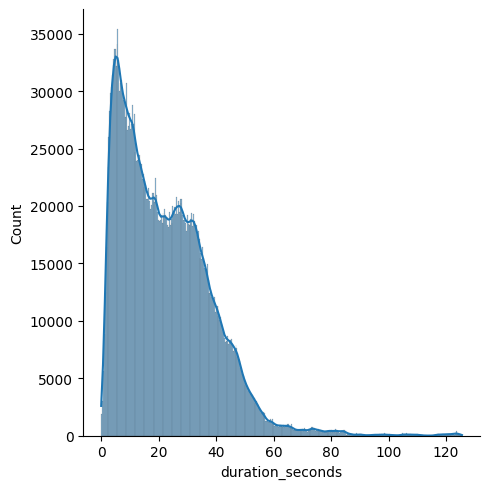

In [79]:
sns.displot(origin_dest_acc['duration_seconds']/60, kde=True)

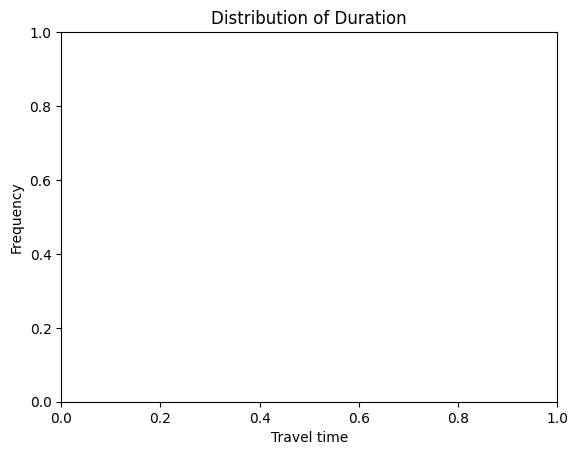

In [80]:
plt.title('Distribution of Duration')
plt.xlabel('Travel time')
plt.ylabel('Frequency')
plt.show()          

<Axes: xlabel='Accessibility_standard', ylabel='population'>

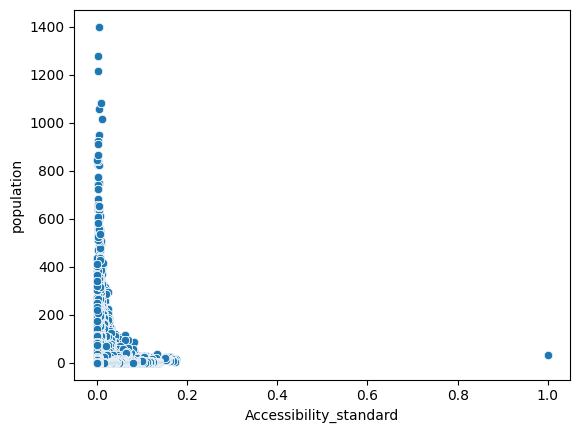

In [81]:
# 3. distribution plot of population/duration
sns.scatterplot(x='Accessibility_standard', y='population', data=origin_dest_acc)

Text(0, 0.5, 'Population')

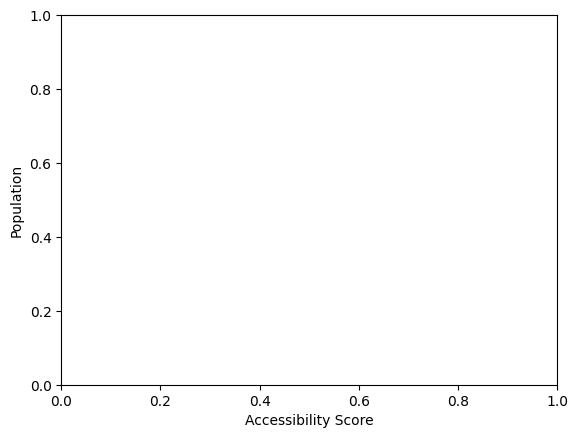

In [82]:
plt.xlabel('Accessibility Score')
plt.ylabel('Population')

In [83]:
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=origin_dest_acc, x='Local_Validation')

In [ ]:
plt.title('Histogram')
plt.xlabel('Local Validation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='facility_name', ylabel='Count'>

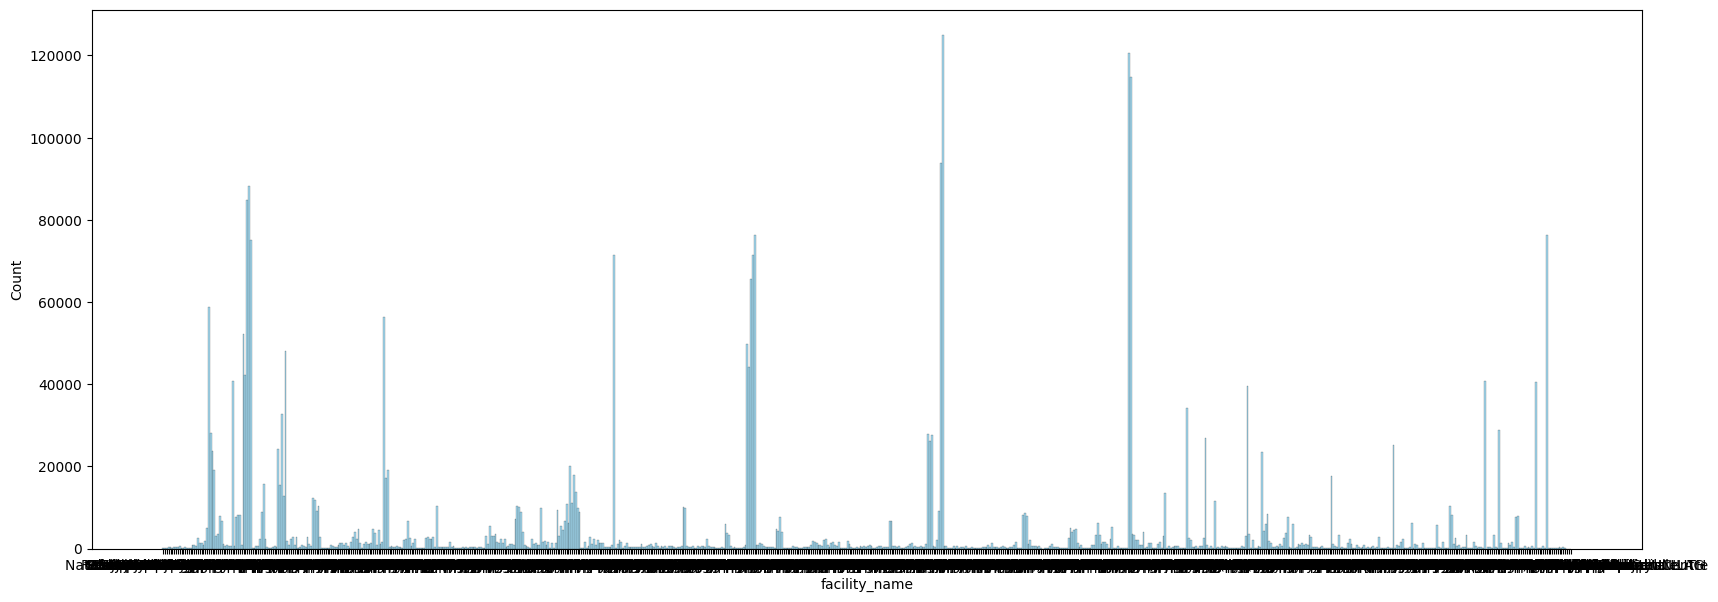

In [84]:
plt.figure(figsize=(20, 7))
sns.histplot(
    data=origin_dest_acc,
    x='facility_name',
    discrete=True,
    color='skyblue',
    edgecolor='black'
)

In [ ]:
plt.title('Facility Name Distribution', fontsize=16)
plt.xlabel('Facility Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
from matplotlib import gridspec

In [ ]:
data_folder = 'data_outputs/acc_score_3_closest_Emoc'

In [ ]:
file_names = [f for f in os.listdir(data_folder) if f.endswith('.gpkg')] 

In [ ]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(4, 5, figure=fig)

In [ ]:
y_labels = ['5min', '10min', '15min', '20min']
x_labels = [0.75, 0.5, 0.1, 0.05, 0.01]

In [ ]:
for i, file_name in enumerate(file_names):
    file_path = os.path.join(data_folder, file_name)
    gdf = gpd.read_file(file_path)

    match = re.search(r'd(\d+)', file_name)
    if match:
        d_value = int(match.group(1))
        y_position = 3 - (d_value // 5 - 1)

    match = re.search(r'w(\d+\.\d+)', file_name)
    if match:
        w_value = float(match.group(1))
        x_position = x_labels.index(w_value)

    ax = fig.add_subplot(gs[y_position, x_position])
    
    sns.scatterplot(x='Accessibility_standard', y='population', data=gdf, ax=ax)
    ax.set_xlabel('Accessibility Score')
    ax.set_ylabel('Population')

In [ ]:
plt.tight_layout()
output_image_path = 'data_outputs/output_image.png'
plt.savefig(output_image_path, bbox_inches='tight', dpi=300)

In [ ]:
plt.show()

# 4. Grouping by grid ID to prepare the final output file
There is a need to update this part of the code

In [3]:
# Read the GeoPackage file (if starting from this section)
results_grid = gpd.read_file(data_temp + 'acc_score_3_closet_Emoc_d10_w0.01_supply_weighted.gpkg')
results_grid = results_grid[['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard', 'geometry']]

Group by multiple columns and calculate the mean for numeric columns
results_grid = results_grid.groupby(['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard']).count().reset_index()

In [4]:
results_grid = results_grid.drop_duplicates(['grid_id', 'origin_lon', 'origin_lat', 'origin_lon_min', 'origin_lat_min', 'origin_lon_max', 'origin_lat_max', 'Accessibility_standard', 'geometry'])

In [89]:
# save the results to a new GeoPackage file
output_gpkg_path = data_temp + 'emergency-maternal-care-deprivation-access.gpkg'
results_grid.to_file(output_gpkg_path, layer='emergency-maternal-care-deprivation-access', driver='GPKG')

In [5]:
type(results_grid)

geopandas.geodataframe.GeoDataFrame

In [88]:
results_grid

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,Accessibility_standard,geometry
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,0.006413,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3...."
5,141529,3.281711,6.613668,3.281208,6.613262,3.282214,6.614073,0.016435,"POLYGON ((3.28121 6.61407, 3.28221 6.61407, 3...."
10,146446,3.290691,6.604748,3.290189,6.604343,3.291194,6.605154,0.027190,"POLYGON ((3.29019 6.60515, 3.29119 6.60515, 3...."
15,146063,3.289166,6.475832,3.288663,6.475427,3.289668,6.476238,0.047526,"POLYGON ((3.28867 6.47624, 3.28967 6.47624, 3...."
20,128815,3.258019,6.452321,3.257516,6.451915,3.258521,6.452726,0.045598,"POLYGON ((3.25752 6.45273, 3.25852 6.45273, 3...."
...,...,...,...,...,...,...,...,...,...
3044921,1602,2.852320,6.449078,2.851818,6.448672,2.852823,6.449483,0.000000,"POLYGON ((2.85182 6.44948, 2.85282 6.44948, 2...."
3044926,1603,2.852318,6.448267,2.851815,6.447862,2.852820,6.448672,0.000000,"POLYGON ((2.85182 6.44867, 2.85282 6.44867, 2...."
3044931,1604,2.852315,6.447456,2.851813,6.447051,2.852817,6.447862,0.000000,"POLYGON ((2.85182 6.44786, 2.85282 6.44786, 2...."
3044936,1682,2.853331,6.451510,2.852828,6.451105,2.853833,6.451915,0.000000,"POLYGON ((2.85283 6.45192, 2.85383 6.45192, 2...."


### Setting values for Low medium and High categories

We started by defining equal value division, and modified the thesholds to a value that is more legible and easier to interpret. Every model should have their own thresholds based on the data distribution of the three categories. 

Note: For Kano, we excluded grid cells with index values below 0.000001 that indicated very low population and a small number of buildings.  

Option 1: Kano
Values are specific for each city and should be adjusted based on the data distribution of the three categories. 


In [ ]:
results_grid['result'] = -1
results_grid.loc[results_grid['Accessibility_standard'] > 0.000001, 'result'] = 2
results_grid.loc[results_grid['Accessibility_standard'] > 0.005, 'result'] = 1
results_grid.loc[results_grid['Accessibility_standard'] > 0.02, 'result'] = 0

Option 2: Lagos
Values are specific for each city and should be adjusted based on the data distribution of the three categories. 

In [8]:
results_grid['result'] = -1
results_grid.loc[results_grid['Accessibility_standard'] > 0.000001, 'result'] = 2
results_grid.loc[results_grid['Accessibility_standard'] > 0.005, 'result'] = 1
results_grid.loc[results_grid['Accessibility_standard'] > 0.02, 'result'] = 0

### Setting values for focus areas

We defined the focus areas based on values for the different thresholds. We aim at participants helping us to confirm the selection of the city-specific thresholds.

Option 1: Kano


In [ ]:
results_grid['focused'] = 0
# Focus areas between the Low category and the excluded cells due to low population or no buildings
results_grid.loc[(results_grid['Accessibility_standard'] > 0.000001) & (results_grid['Accessibility_standard'] < 0.0000015), 'focused'] = 1
# Focus areas between the Medium and High categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.003) & (results_grid['Accessibility_standard'] < 0.006), 'focused'] = 1
# Focus areas between the Low and Medium categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.019) & (results_grid['Accessibility_standard'] < 0.03), 'focused'] = 1

Option 2: Lagos

In [9]:
results_grid['focused'] = 0
# Focus areas between the Low category and city expansion areas
# results_grid.loc[(results_grid['Accessibility_standard'] > 0.000001) & (results_grid['Accessibility_standard'] < 0.0000015), 'focused'] = 1
# Focus areas between the Medium and High categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.003) & (results_grid['Accessibility_standard'] < 0.006), 'focused'] = 1
# Focus areas between the Low and Medium categories
results_grid.loc[(results_grid['Accessibility_standard'] > 0.019) & (results_grid['Accessibility_standard'] < 0.03), 'focused'] = 1

In [12]:
results_grid

,grid_id,origin_lon,origin_lat,origin_lon_min,origin_lat_min,origin_lon_max,origin_lat_max,Accessibility_standard,geometry,result,focused
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,0.006413,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",1,0
5,141529,3.281711,6.613668,3.281208,6.613262,3.282214,6.614073,0.016435,"POLYGON ((3.28121 6.61407, 3.28221 6.61407, 3....",1,0
10,146446,3.290691,6.604748,3.290189,6.604343,3.291194,6.605154,0.027190,"POLYGON ((3.29019 6.60515, 3.29119 6.60515, 3....",0,1
15,146063,3.289166,6.475832,3.288663,6.475427,3.289668,6.476238,0.047526,"POLYGON ((3.28867 6.47624, 3.28967 6.47624, 3....",0,0
20,128815,3.258019,6.452321,3.257516,6.451915,3.258521,6.452726,0.045598,"POLYGON ((3.25752 6.45273, 3.25852 6.45273, 3....",0,0
...,...,...,...,...,...,...,...,...,...,...,...
1655835,325206,3.810044,6.471779,3.809541,6.471373,3.810547,6.472184,0.000002,"POLYGON ((3.80955 6.47218, 3.81055 6.47218, 3....",2,0
1665238,325174,3.809043,6.471779,3.808540,6.471373,3.809545,6.472184,0.000001,"POLYGON ((3.80854 6.47218, 3.80955 6.47218, 3....",2,0
1673724,325142,3.808041,6.471779,3.807538,6.471373,3.808544,6.472184,0.000001,"POLYGON ((3.80754 6.47218, 3.80854 6.47218, 3....",2,0
1674779,325236,3.811050,6.472589,3.810547,6.472184,3.811552,6.472995,0.000001,"POLYGON ((3.81055 6.47299, 3.81155 6.47299, 3....",2,0


In [11]:
results_grid = results_grid.loc[results_grid['result'] != -1]

In [13]:
results_grid = results_grid.rename(columns={
    'origin_lon': 'longitude',
    'origin_lat': 'latitude',
    'origin_lon_min': 'lon_min',
    'origin_lat_min': 'lat_min',
    'origin_lon_max': 'lon_max',
    'origin_lat_max': 'lat_max'
})

In [14]:
results_grid

,grid_id,longitude,latitude,lon_min,lat_min,lon_max,lat_max,Accessibility_standard,geometry,result,focused
0,167539,3.331182,6.462050,3.330680,6.461644,3.331685,6.462455,0.006413,"POLYGON ((3.33068 6.46245, 3.33168 6.46245, 3....",1,0
5,141529,3.281711,6.613668,3.281208,6.613262,3.282214,6.614073,0.016435,"POLYGON ((3.28121 6.61407, 3.28221 6.61407, 3....",1,0
10,146446,3.290691,6.604748,3.290189,6.604343,3.291194,6.605154,0.027190,"POLYGON ((3.29019 6.60515, 3.29119 6.60515, 3....",0,1
15,146063,3.289166,6.475832,3.288663,6.475427,3.289668,6.476238,0.047526,"POLYGON ((3.28867 6.47624, 3.28967 6.47624, 3....",0,0
20,128815,3.258019,6.452321,3.257516,6.451915,3.258521,6.452726,0.045598,"POLYGON ((3.25752 6.45273, 3.25852 6.45273, 3....",0,0
...,...,...,...,...,...,...,...,...,...,...,...
1655835,325206,3.810044,6.471779,3.809541,6.471373,3.810547,6.472184,0.000002,"POLYGON ((3.80955 6.47218, 3.81055 6.47218, 3....",2,0
1665238,325174,3.809043,6.471779,3.808540,6.471373,3.809545,6.472184,0.000001,"POLYGON ((3.80854 6.47218, 3.80955 6.47218, 3....",2,0
1673724,325142,3.808041,6.471779,3.807538,6.471373,3.808544,6.472184,0.000001,"POLYGON ((3.80754 6.47218, 3.80854 6.47218, 3....",2,0
1674779,325236,3.811050,6.472589,3.810547,6.472184,3.811552,6.472995,0.000001,"POLYGON ((3.81055 6.47299, 3.81155 6.47299, 3....",2,0


In [15]:
# Save the results to a new GeoPackage file
output_gpkg_path = data_temp + 'emergency-maternal-care-deprivation-access-class.gpkg'
results_grid.to_file(output_gpkg_path, layer='emergency-maternal-care-deprivation-access-class', driver='GPKG')

In [16]:
# Save the results to a CSV file in the format required by the IDEAMAPS data ecosystem
results_table = results_grid.drop(columns=['Accessibility_standard', 'grid_id', 'geometry'])
results_table.to_csv(model_outputs + 'model-output.csv', index=False)

In [ ]:
results_table